Key Imports

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as dataread
from fredapi import Fred
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.ticker import FuncFormatter
import requests
from io import StringIO
import praw
from RedditCollector import RedditCollector
from tqdm import tqdm

Define Font Family for Charts

In [2]:
plt.rcParams['font.family'] = 'Arial'

Establish Connection to FRED API

In [3]:
fred = Fred(api_key = "2d6b745c3b251fcb70ae1c8985c399e1")

Get Historical Data on 5Y5Y Breakeven Yields from FRED

In [4]:
breakeven_data = fred.get_series("DFII5")
breakeven_df = pd.DataFrame({
    "date": pd.to_datetime(breakeven_data.index),
    "yield": breakeven_data.values
})

Get Historical Gold Spot Price Data from Yahoo Finance

In [5]:
gold_data = yf.download("GC=F", start="2022-01-01", end="2026-02-04")
gold_df = gold_data[['Close']].reset_index()
gold_df.columns = ['date', 'price']

/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_57081/2891169358.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download("GC=F", start="2022-01-01", end="2026-02-04")
[*********************100%***********************]  1 of 1 completed


Merge Data on Date

In [6]:
data_df = gold_df.merge(breakeven_df, on="date", how="inner")

Plot Data

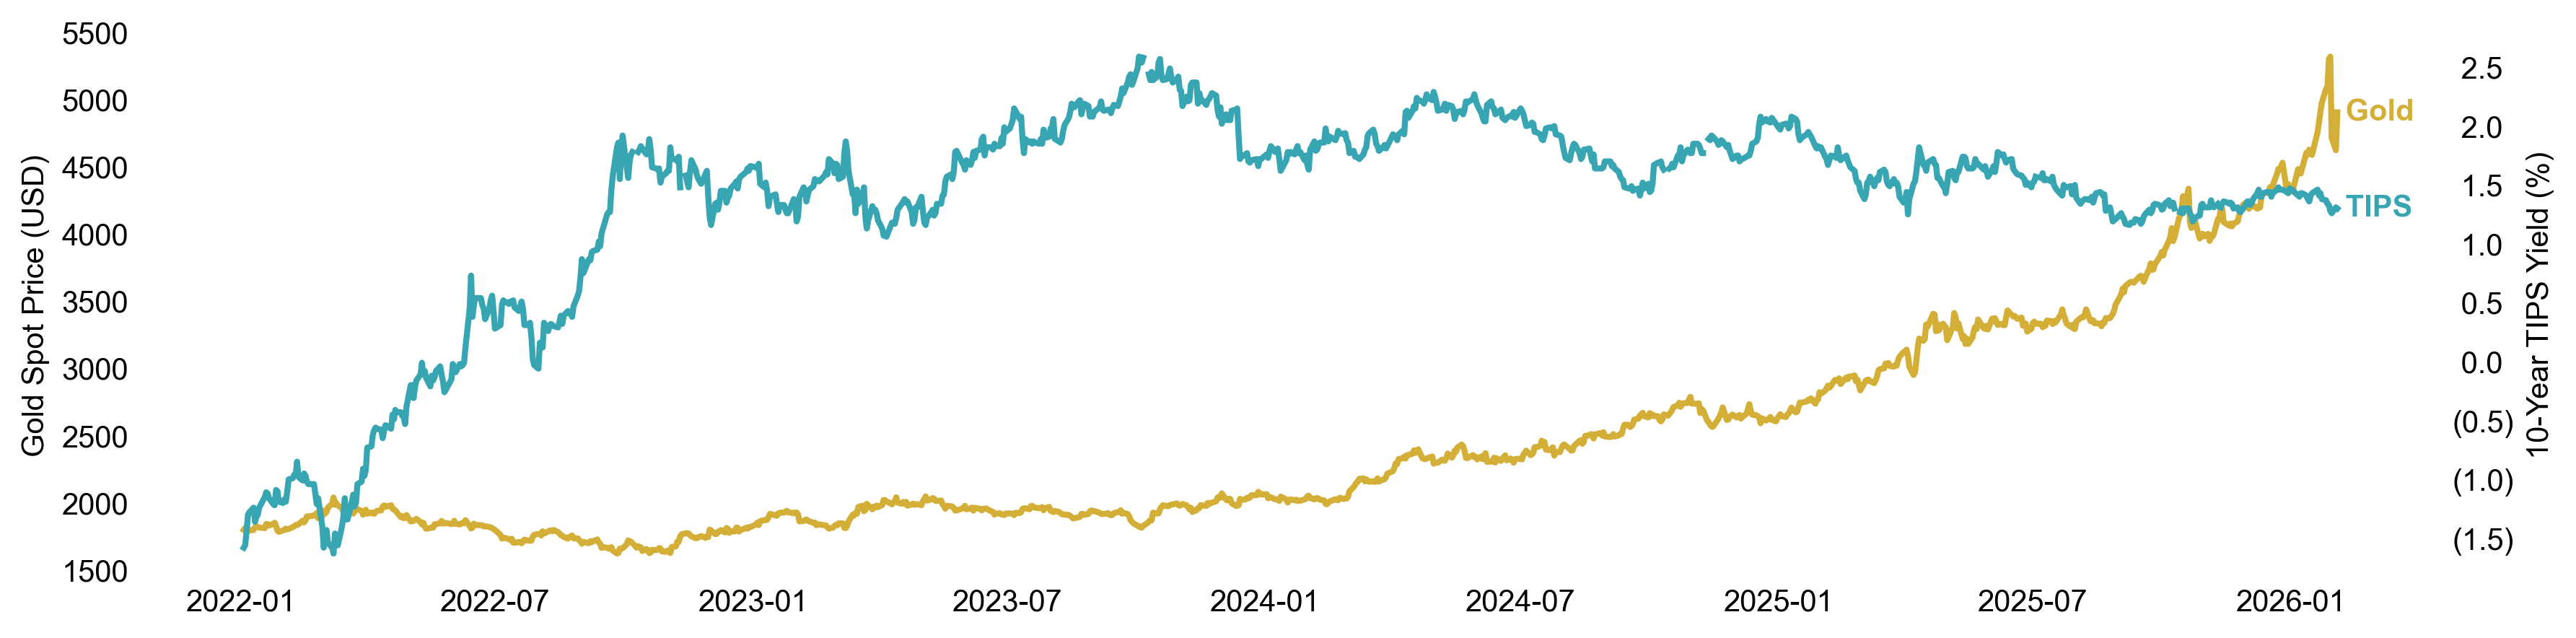

In [7]:
fig, ax1 = plt.subplots(figsize = (12,3), dpi = 300)
ax1.plot(data_df["date"], data_df["price"], color = "#D4AF37", linewidth = 2, label = "Gold Spot Price (USD)")
ax1.set_ylabel("Gold Spot Price (USD)", color = "black", fontsize = 10)
ax1.tick_params(axis = "y", length=0)
ax1.tick_params(axis = "x", length=0)

ax2 = ax1.twinx()
ax2.plot(data_df["date"], data_df["yield"], color = "#38A5B2", linewidth = 2, label = "10Y TIPS Yield")
ax2.set_ylabel("10-Year TIPS Yield (%)", color = "black", fontsize = 10)
ax2.tick_params(axis = "y", length=0)

ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))

from matplotlib.ticker import FuncFormatter
def format_negative(x, pos):
    if x < 0:
        return f'({abs(x):.1f})'
    else:
        return f' {x:.1f} '

ax2.yaxis.set_major_formatter(FuncFormatter(format_negative))

last_date = data_df["date"].iloc[-1]
last_gold_price = data_df["price"].iloc[-1]
last_tips_yield = data_df["yield"].iloc[-1]

ax1.text(last_date, last_gold_price, ' Gold', fontsize=10, color='#D4AF37', 
         va='center', ha='left', weight='bold')
ax2.text(last_date, last_tips_yield, ' TIPS', fontsize=10, color='#38A5B2', 
         va='center', ha='left', weight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

ax1.grid(False)
fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gold_and_tips.png")
plt.show()

Calculate Daily Returns and Yield Changes

In [8]:
data = data_df[['date', 'price', 'yield']].copy()
data = data.set_index('date')

data['yield'] = data['yield'].ffill()
data['yield_chg'] = data['yield'].diff()
data['gold_return'] = data['price'].pct_change()

Calculate Rolling Beta Series Inputs and Plug

In [9]:
rolling_cov = data['gold_return'].rolling(window=52).cov(data['yield_chg'])
rolling_var = data['yield_chg'].rolling(window=52).var()
rolling_beta = (rolling_cov / rolling_var).dropna()

Plot Rolling Beta

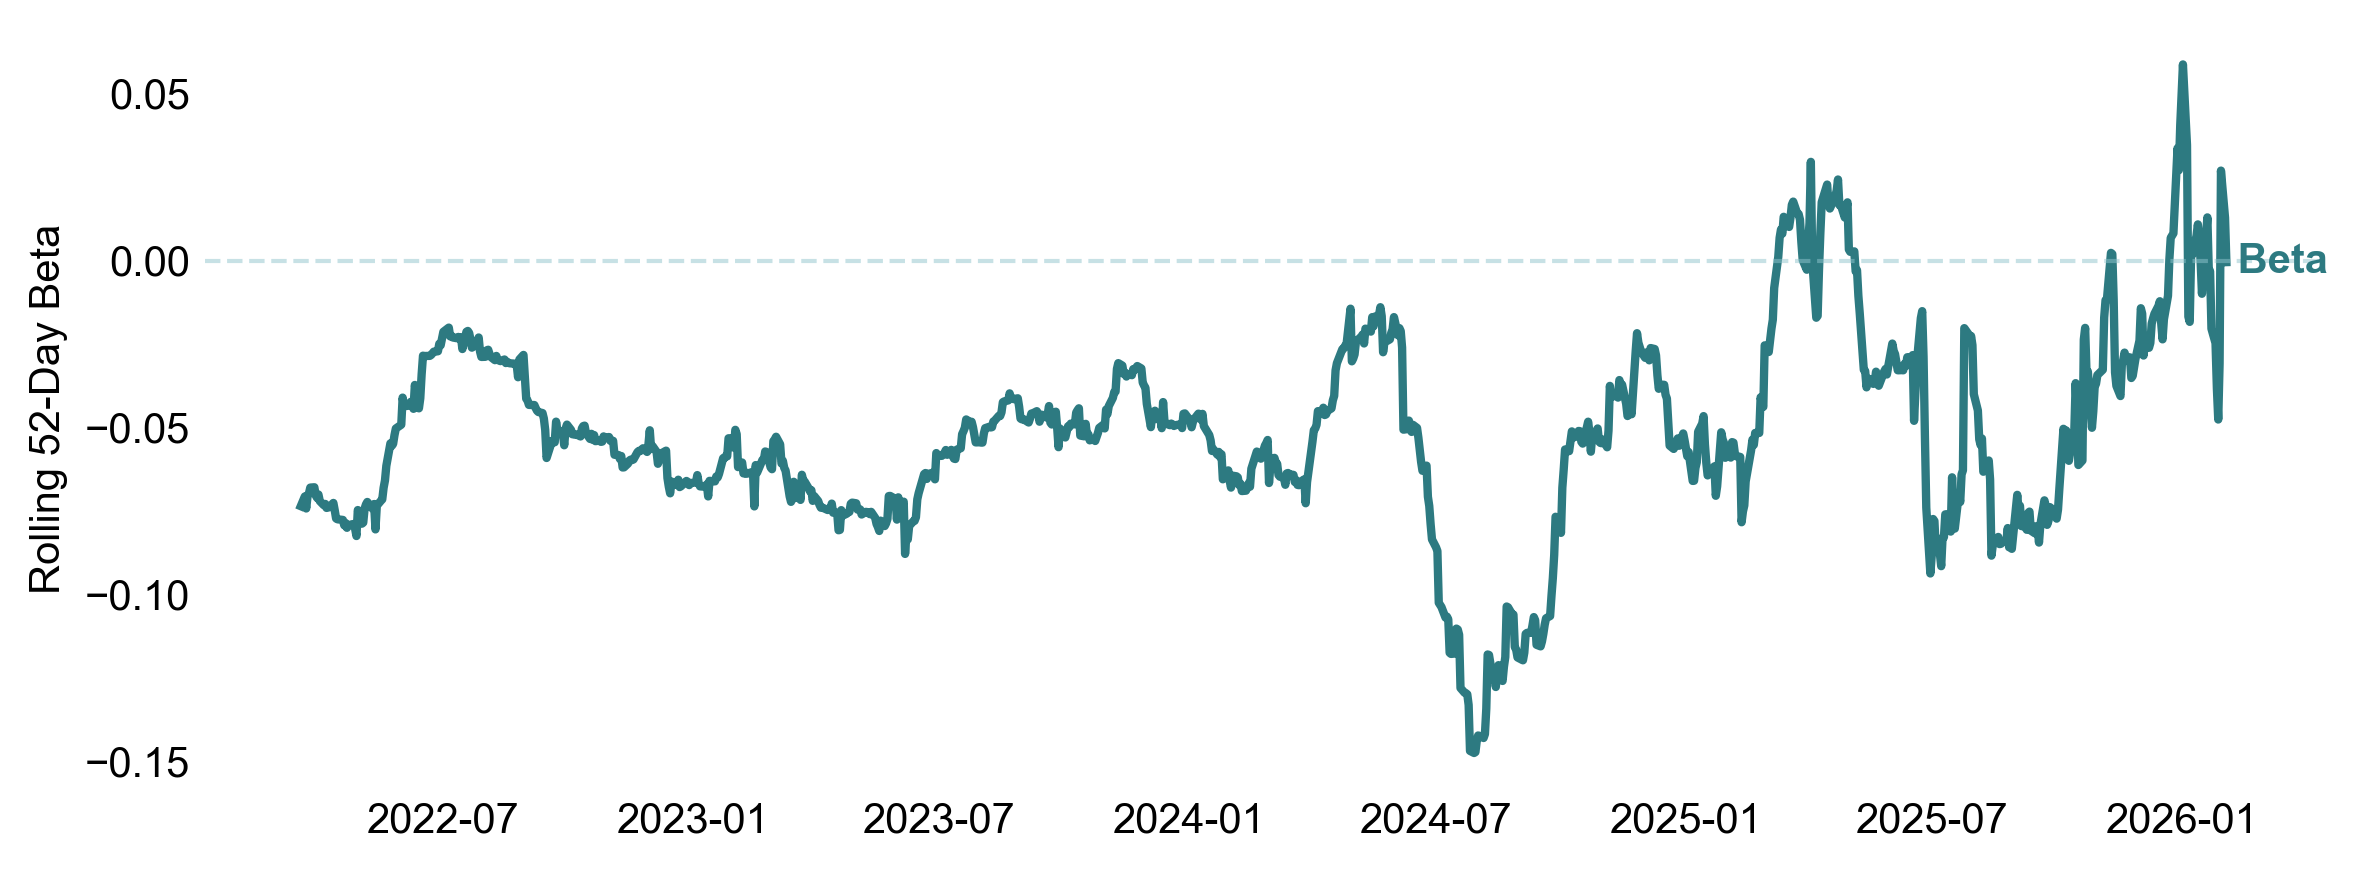

In [10]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

ax.plot(rolling_beta.index, rolling_beta, color='#2D7A81', linewidth=2)
ax.axhline(y=0, color='#90C5CD', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('Rolling 52-Day Beta', fontsize=10)
ax.tick_params(axis='both', length=0)

last_date = rolling_beta.index[-1]
last_beta = rolling_beta.iloc[-1]
ax.text(last_date, last_beta, ' Beta', fontsize=10, color='#2D7A81', 
        va='center', ha='left', weight='bold')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(False)
fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gold_tips_beta.png")
plt.show()

Import Google Trends Data for "how to buy Gold" searches in Canada/US

In [11]:
ca_searches = pd.read_csv("/Users/jdawg/Downloads/ca_2010_search.csv")
ca_searches.rename(columns={"how to buy gold":"CA Interest", 
                            "Time":"date"}, 
                   inplace=True)

us_searches = pd.read_csv("/Users/jdawg/Downloads/us_2010_search.csv")
us_searches.rename(columns={"how to buy gold":"US Interest",
                           "Time":"date"},
                   inplace=True)

ca_us_searches = ca_searches.merge(us_searches, how="inner", on="date")
ca_us_searches['date'] = pd.to_datetime(ca_us_searches['date'])

Get GLD Price and Volume Data from Yahoo Finance

In [12]:
gld_data = yf.download("GLD", start="2010-01-01", end="2026-02-04")
gld_df = gld_data[['Close', 'Volume']].reset_index()
gld_df.columns = ['date', 'gld_price', 'gld_volume']

/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_57081/1564307173.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gld_data = yf.download("GLD", start="2010-01-01", end="2026-02-04")
[*********************100%***********************]  1 of 1 completed


Merge GLD Data on Google Trends Data

In [13]:
gold_gld_df = gld_df.merge(ca_us_searches, how="inner", on="date")

Plot GLD and Search Data

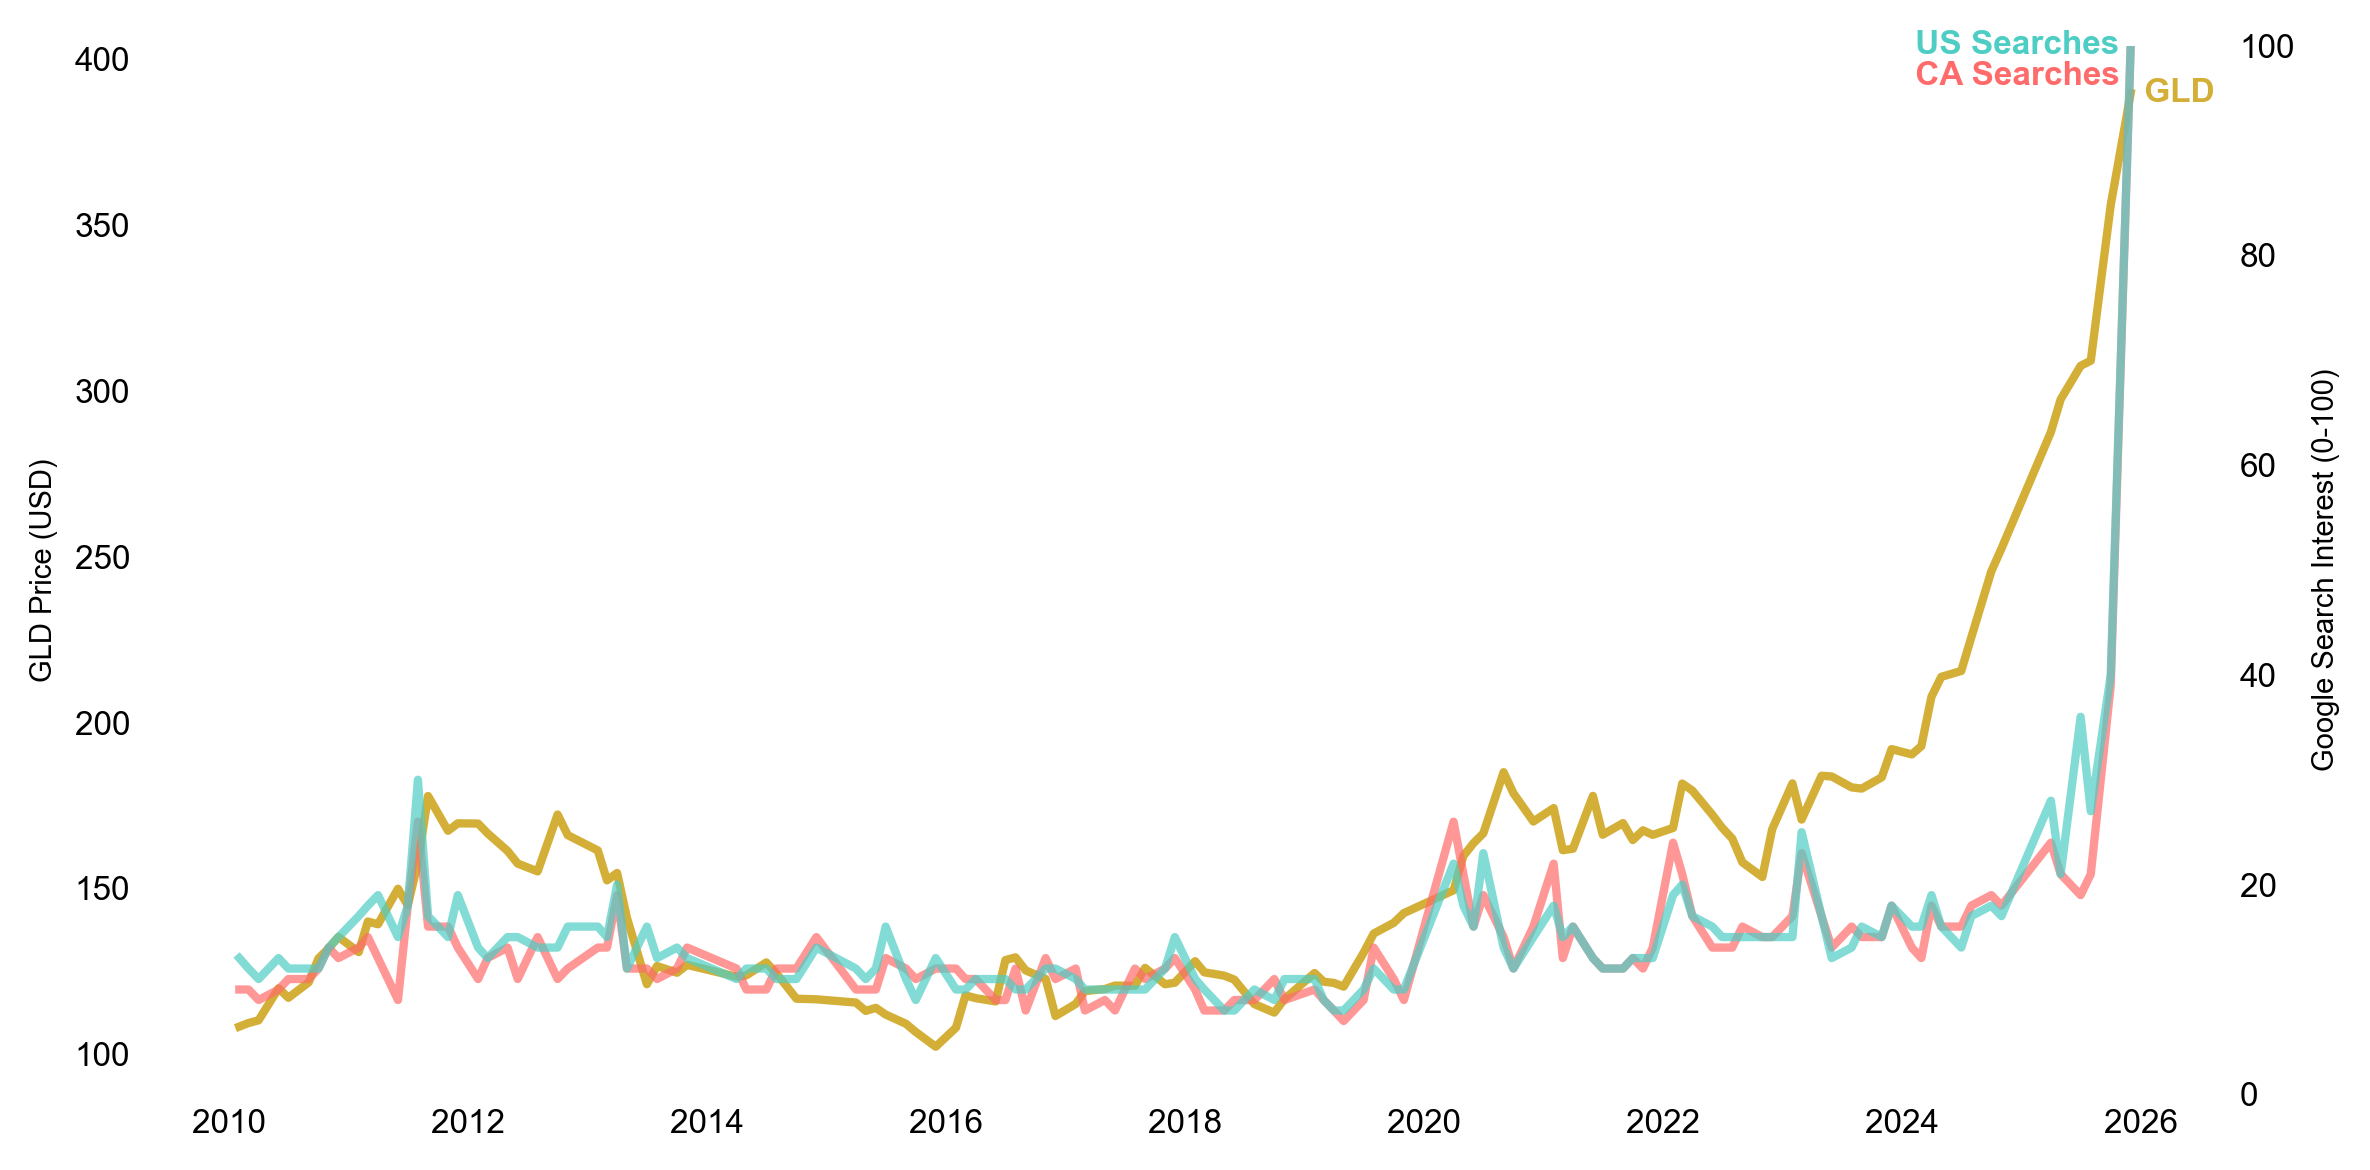

In [14]:
fig, ax1 = plt.subplots(figsize=(8, 4), dpi=300)
# Plot gld price on left axis
ax1.plot(gold_gld_df["date"], gold_gld_df["gld_price"], color="#D4AF37", linewidth=2, label="GLD Price (USD)")
ax1.set_ylabel("GLD Price (USD)", color="black", fontsize=7)
ax1.tick_params(axis="y", length=0, labelsize=8)  # Added labelsize
ax1.tick_params(axis="x", length=0, labelsize=8)  # Added labelsize
# Create right axis for Google Trends interest
ax2 = ax1.twinx()
# Plot both CA and US interest
ax2.plot(gold_gld_df["date"], gold_gld_df["CA Interest"], color="#FF6B6B", linewidth=2, alpha=0.7, label="CA Search Interest")
ax2.plot(gold_gld_df["date"], gold_gld_df["US Interest"], color="#4ECDC4", linewidth=2, alpha=0.7, label="US Search Interest")
ax2.set_ylabel("Google Search Interest (0-100)", color="black", fontsize=7)
ax2.tick_params(axis="y", length=0, labelsize=8)  # Added labelsize
ax2.set_ylim(0, 100)  # Google Trends scale is 0-100
ax2.yaxis.set_major_locator(plt.MultipleLocator(20))
# Add labels at the end
last_date = gold_gld_df["date"].iloc[-1]
last_gld = gold_gld_df["gld_price"].iloc[-1]
last_ca = gold_gld_df["CA Interest"].iloc[-1]
last_us = gold_gld_df["US Interest"].iloc[-1]
x_offset = pd.Timedelta(weeks=52)
ax1.text(last_date+pd.Timedelta(weeks=2), last_gld, ' GLD', fontsize=8, color='#D4AF37', 
         va='center', ha='left', weight='bold')
ax2.text(last_date-x_offset-pd.Timedelta(weeks=46), last_ca-3, ' CA Searches', fontsize=8, color='#FF6B6B', 
         va='center', ha='left', weight='bold')
ax2.text(last_date-x_offset-pd.Timedelta(weeks=46), last_us, ' US Searches', fontsize=8, color='#4ECDC4', 
         va='center', ha='left', weight='bold')
# Remove spines
for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax1.grid(False)
fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gold_search_interest.png", bbox_inches='tight')
plt.show()

Get Data on Chinese Holdings of US Treasuries

In [15]:
url = "https://ticdata.treasury.gov/resource-center/data-chart-center/tic/Documents/slt_table5.html"
tables = pd.read_html(url)
df = tables[0]

Isolate Chinese Holdings

In [16]:
df

,Table 5: Major Foreign Holders of Treasury Securities,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Holdings at end of time period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Billions of dollars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Link: https://ticdata.treasury.gov/resource-ce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Country,2025-11,2025-10,2025-09,2025-08,2025-07,2025-06,2025-05,2025-04,2025-03,2025-02,2025-01,2024-12,2024-11
5,Japan,1202.6,1200.0,1189.3,1180.4,1151.8,1148.0,1135.0,1134.5,1130.8,1125.9,1079.3,1061.5,1087.1
6,United Kingdom,888.5,877.9,864.7,904.3,899.3,857.9,809.4,807.7,779.3,750.3,740.2,722.8,766.9
7,"China, Mainland",682.6,688.7,700.5,701.0,696.9,732.7,732.7,743.6,765.4,784.3,760.8,759.0,768.6
8,Belgium,481.0,468.4,466.9,454.3,428.3,433.4,415.5,411.1,402.1,394.7,377.7,374.6,361.3
9,Canada,472.2,419.1,475.8,443.7,381.4,438.2,430.1,368.4,426.2,406.1,350.8,378.8,372.4


In [17]:
df = df.dropna()
china_data = df[(df["Table 5: Major Foreign Holders of Treasury Securities"]=="China, Mainland")|(df["Table 5: Major Foreign Holders of Treasury Securities"]=="Country")]

Pivot and Clean Data

In [18]:
dates = china_data.iloc[0, 1:].values  # First row, skip first column
china_holdings = china_data.iloc[1, 1:].values  # Second row, skip first column

china_df = pd.DataFrame({
    'date': dates,
    'holdings': china_holdings
})

china_df['date'] = pd.to_datetime(china_df['date'])

china_df['holdings'] = pd.to_numeric(china_df['holdings'], errors='coerce')

china_df = china_df.sort_values('date').reset_index(drop=True)

Import Chinese Gold Holdings Data

In [19]:
gold_holdings = pd.read_csv("/Users/jdawg/Downloads/gold_holdings.csv")

gold_pivoted = gold_holdings.set_index('Country').T.reset_index().rename(columns={'index': 'Quarter'})

quarter_map = {
    'Q1 25': '2025-03-31',
    'Q2 25': '2025-06-30', 
    'Q3 25': '2025-09-30',
    'Q4 25': '2025-12-31'
}

gold_pivoted['Quarter'] = gold_pivoted['Quarter'].map(quarter_map)

gold_pivoted['Quarter'] = pd.to_datetime(gold_pivoted['Quarter'])

gold_pivoted

Country,Quarter,United States of America,Germany,Italy,France,Russian Federation,China,Switzerland,India,Japan,...,Mauritania,Cameroon,Eritrea,Malawi,Gabon,Chad,Congo,Burundi,Turkmenistan,Myanmar
0,2025-03-31,8133.46,3351.28,2451.84,2437,2329.63,2292.31,1039.94,879.58,845.97,...,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED
1,2025-06-30,8133.46,3350.25,2451.84,2437,2329.63,2298.53,1039.94,879.98,845.97,...,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED
2,2025-09-30,8133.46,3350.25,2451.84,2437,2329.63,2303.51,1039.94,880.17,845.97,...,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED
3,2025-12-31,AWAITED,AWAITED,2451.87,AWAITED,2326.52,2306.3,AWAITED,880.17,845.97,...,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED,AWAITED


NameError: name 'china_combined' is not defined

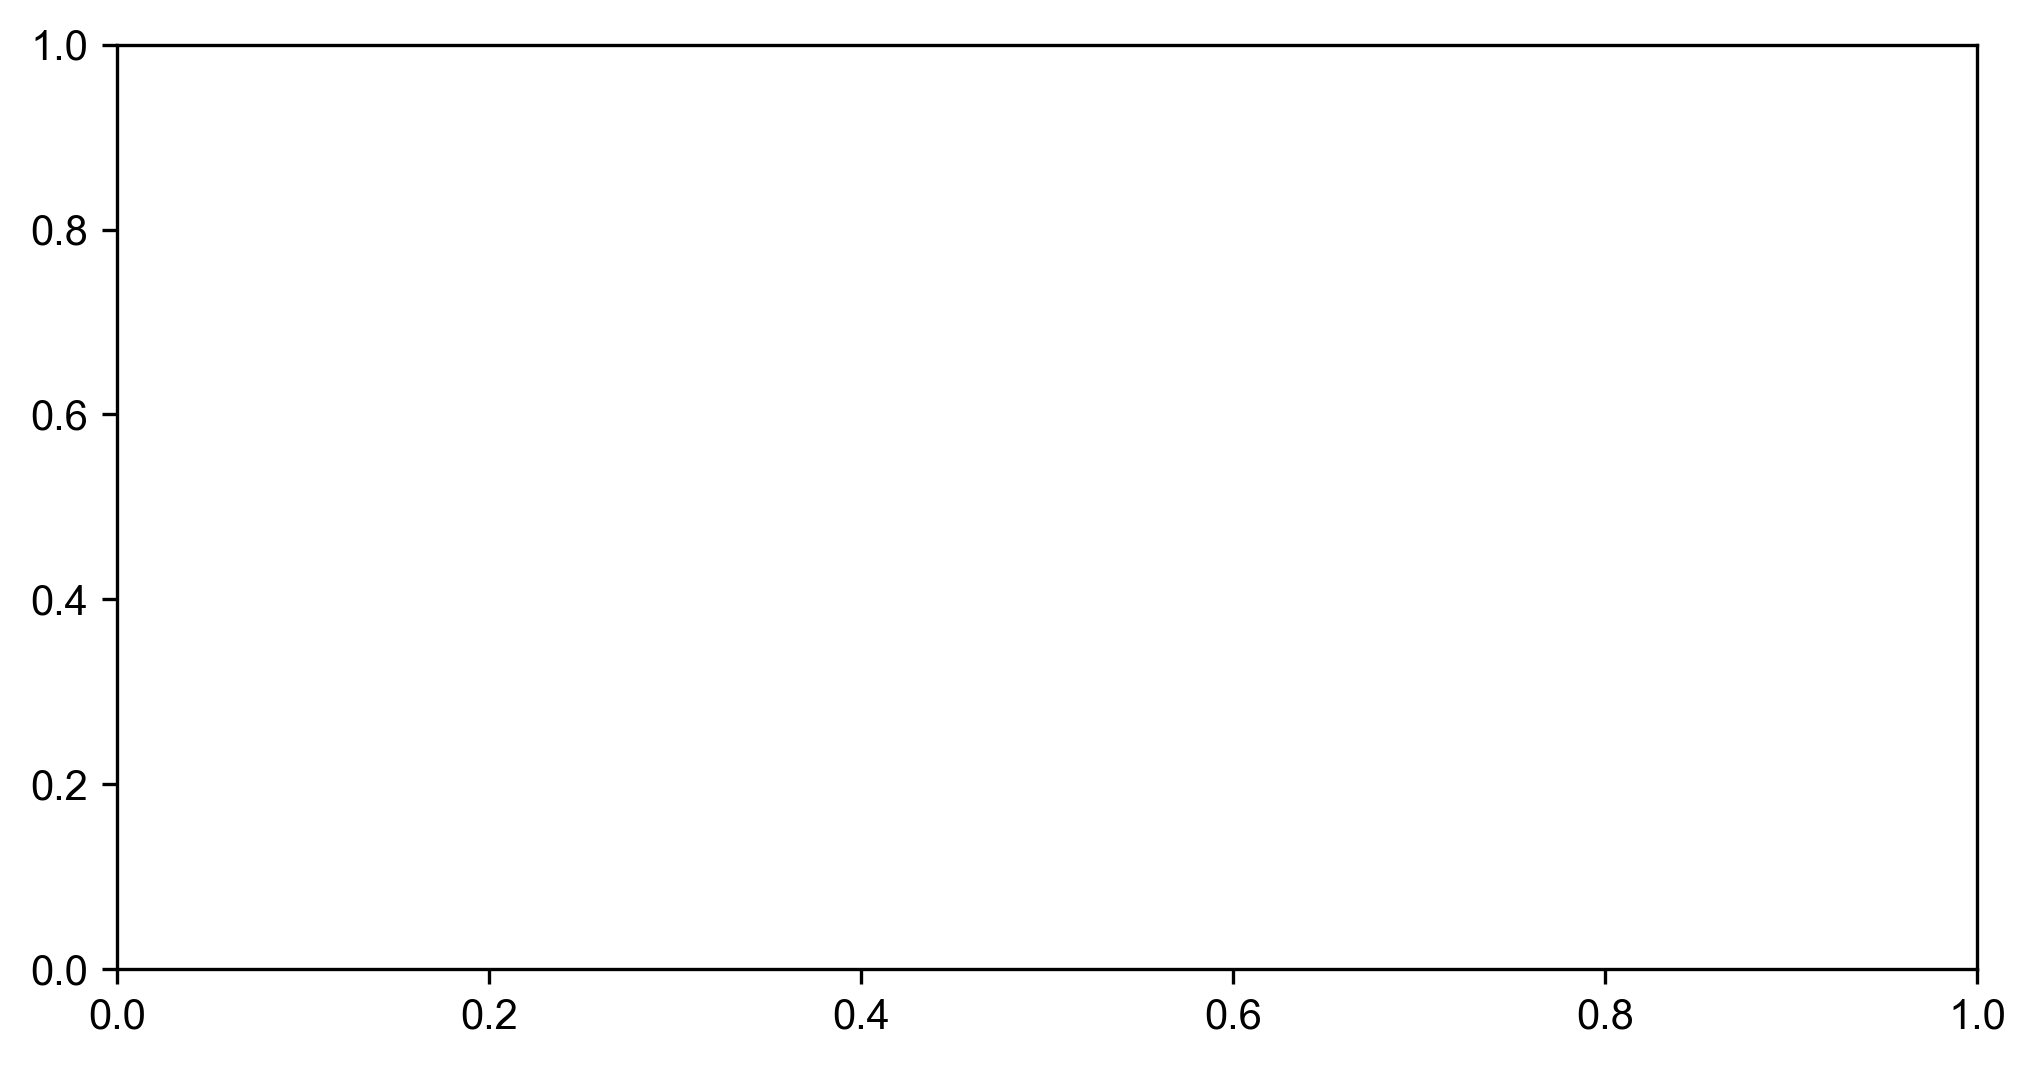

In [20]:
# Create stacked percentage bar chart with 20-30% range
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

x = range(len(china_combined))
width = 0.6

ax.bar(x, china_combined['Treasury_Pct'], width, label='US Treasuries', color='#7DCED9')
ax.bar(x, china_combined['Gold_Pct'], width, bottom=china_combined['Treasury_Pct'], 
       label='Gold', color='#D4AF37')

ax.set_xticks(x)

# Format quarter labels properly
quarter_labels = [f"{date.year} Q{(date.month-1)//3 + 1}" for date in china_combined['date']]
ax.set_xticklabels(quarter_labels, ha='center')

ax.set_ylim(20, 30)  # Fixed 20-30% range
ax.legend(loc='upper right')

# Remove gridlines
ax.grid(False)

# Remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove tick marks (but keep labels)
ax.tick_params(axis='both', which='both', length=0)

plt.savefig("/Users/jdawg/Desktop/china_holdings.png")
plt.tight_layout()
plt.show()

# Print changes
print("\nAllocation Changes:")
print(china_combined[['date', 'Treasury_Pct', 'Gold_Pct']])

print("\nAbsolute Change (Q1 2025 to Q4 2025):")
if len(china_combined) > 0:
    treasury_change = china_combined['Treasury_Pct'].iloc[-1] - china_combined['Treasury_Pct'].iloc[0]
    gold_change = china_combined['Gold_Pct'].iloc[-1] - china_combined['Gold_Pct'].iloc[0]
    print(f"Treasury: {treasury_change:+.2f} percentage points")
    print(f"Gold: {gold_change:+.2f} percentage points")

Import GLD Open Interest Data from Bloomberg

In [21]:
gld_oi_data = pd.read_csv("/Users/jdawg/Downloads/gld_open_interest.csv")

In [22]:
gld_oi_data = gld_oi_data.dropna(how='all')

In [23]:
gld_oi_data_filtered = gld_oi_data[["Date", "Sum of OI"]]

In [24]:
gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].replace(0, np.nan)
gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].fillna(method='ffill')

/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_57081/1714122563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].replace(0, np.nan)
/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_57081/1714122563.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].fillna(method='ffill')
/var/folders/0c/gwf3kkss2ls74cgdgxp9q88r0000gn/T/ipykernel_57081/1714122563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Date range: 2025-01-03 00:00:00 to 2025-12-19 00:00:00
Number of weeks: 52


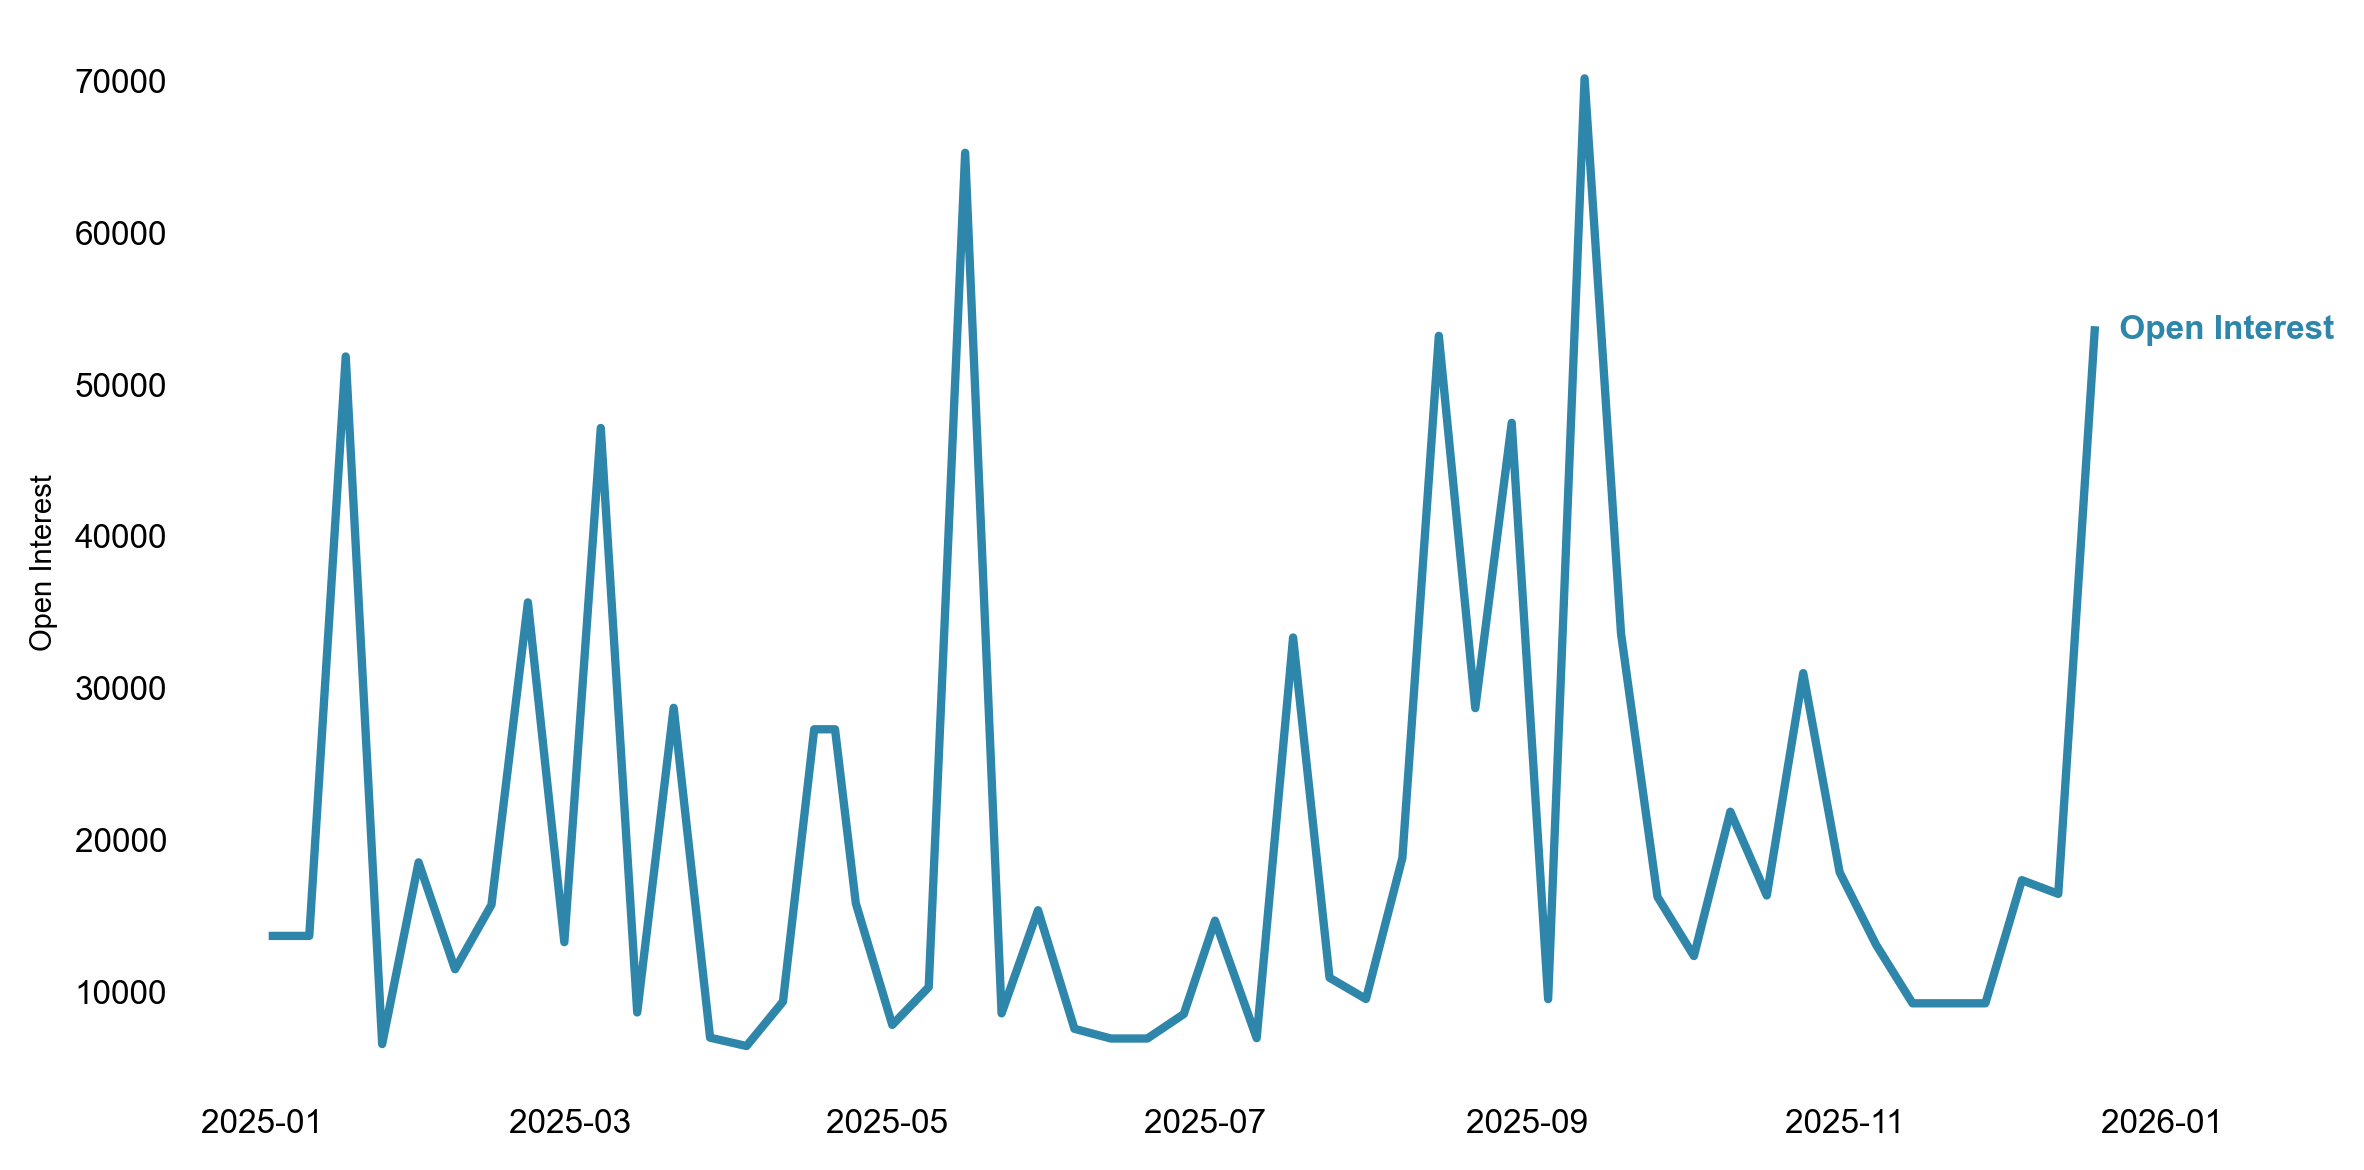


✓ Plot saved to: /Users/jdawg/Desktop/gld_weekly_open_interest.png


In [33]:
# ===================================================================
# Plot GLD Weekly Open Interest Over Time (Clean Style)
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and prepare data
gld_oi_data = pd.read_csv("/Users/jdawg/Downloads/gld_open_interest.csv")
gld_oi_data = gld_oi_data.dropna(how='all')
gld_oi_data_filtered = gld_oi_data[["Date", "Sum of OI"]].copy()

# Clean the data
gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].replace(0, np.nan)
gld_oi_data_filtered["Sum of OI"] = gld_oi_data_filtered["Sum of OI"].ffill()
gld_oi_data_filtered['Date'] = pd.to_datetime(gld_oi_data_filtered['Date'])

# Remove any remaining NaN values
gld_oi_data_filtered = gld_oi_data_filtered.dropna()

print(f"Date range: {gld_oi_data_filtered['Date'].min()} to {gld_oi_data_filtered['Date'].max()}")
print(f"Number of weeks: {len(gld_oi_data_filtered)}")

# ===================================================================
# Create the plot in your clean style
# ===================================================================

fig, ax1 = plt.subplots(figsize=(8, 4), dpi=300)

# Plot open interest
ax1.plot(gld_oi_data_filtered["Date"], 
         gld_oi_data_filtered["Sum of OI"], 
         color="#2E86AB", 
         linewidth=2, 
         label="Open Interest")

ax1.set_ylabel("Open Interest", color="black", fontsize=7)
ax1.tick_params(axis="y", length=0, labelsize=8)
ax1.tick_params(axis="x", length=0, labelsize=8)

# Add label at the end
last_date = gld_oi_data_filtered["Date"].iloc[-1]
last_oi = gld_oi_data_filtered["Sum of OI"].iloc[-1]

ax1.text(last_date + pd.Timedelta(days=3), last_oi, ' Open Interest', 
         fontsize=8, color='#2E86AB', va='center', ha='left', weight='bold')

# Remove spines
for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.grid(False)

fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/gld_weekly_open_interest.png", bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: /Users/jdawg/Desktop/gld_weekly_open_interest.png")

Import 2s10s Data from FRED (CSV)

In [43]:
ten_two = pd.read_csv("/Users/jdawg/Downloads/T10Y2Y.csv")
ten_two.columns

Index(['observation_date', 'T10Y2Y'], dtype='object')

Date range: 2025-01-02 00:00:00 to 2026-01-01 00:00:00
Number of weeks: 261


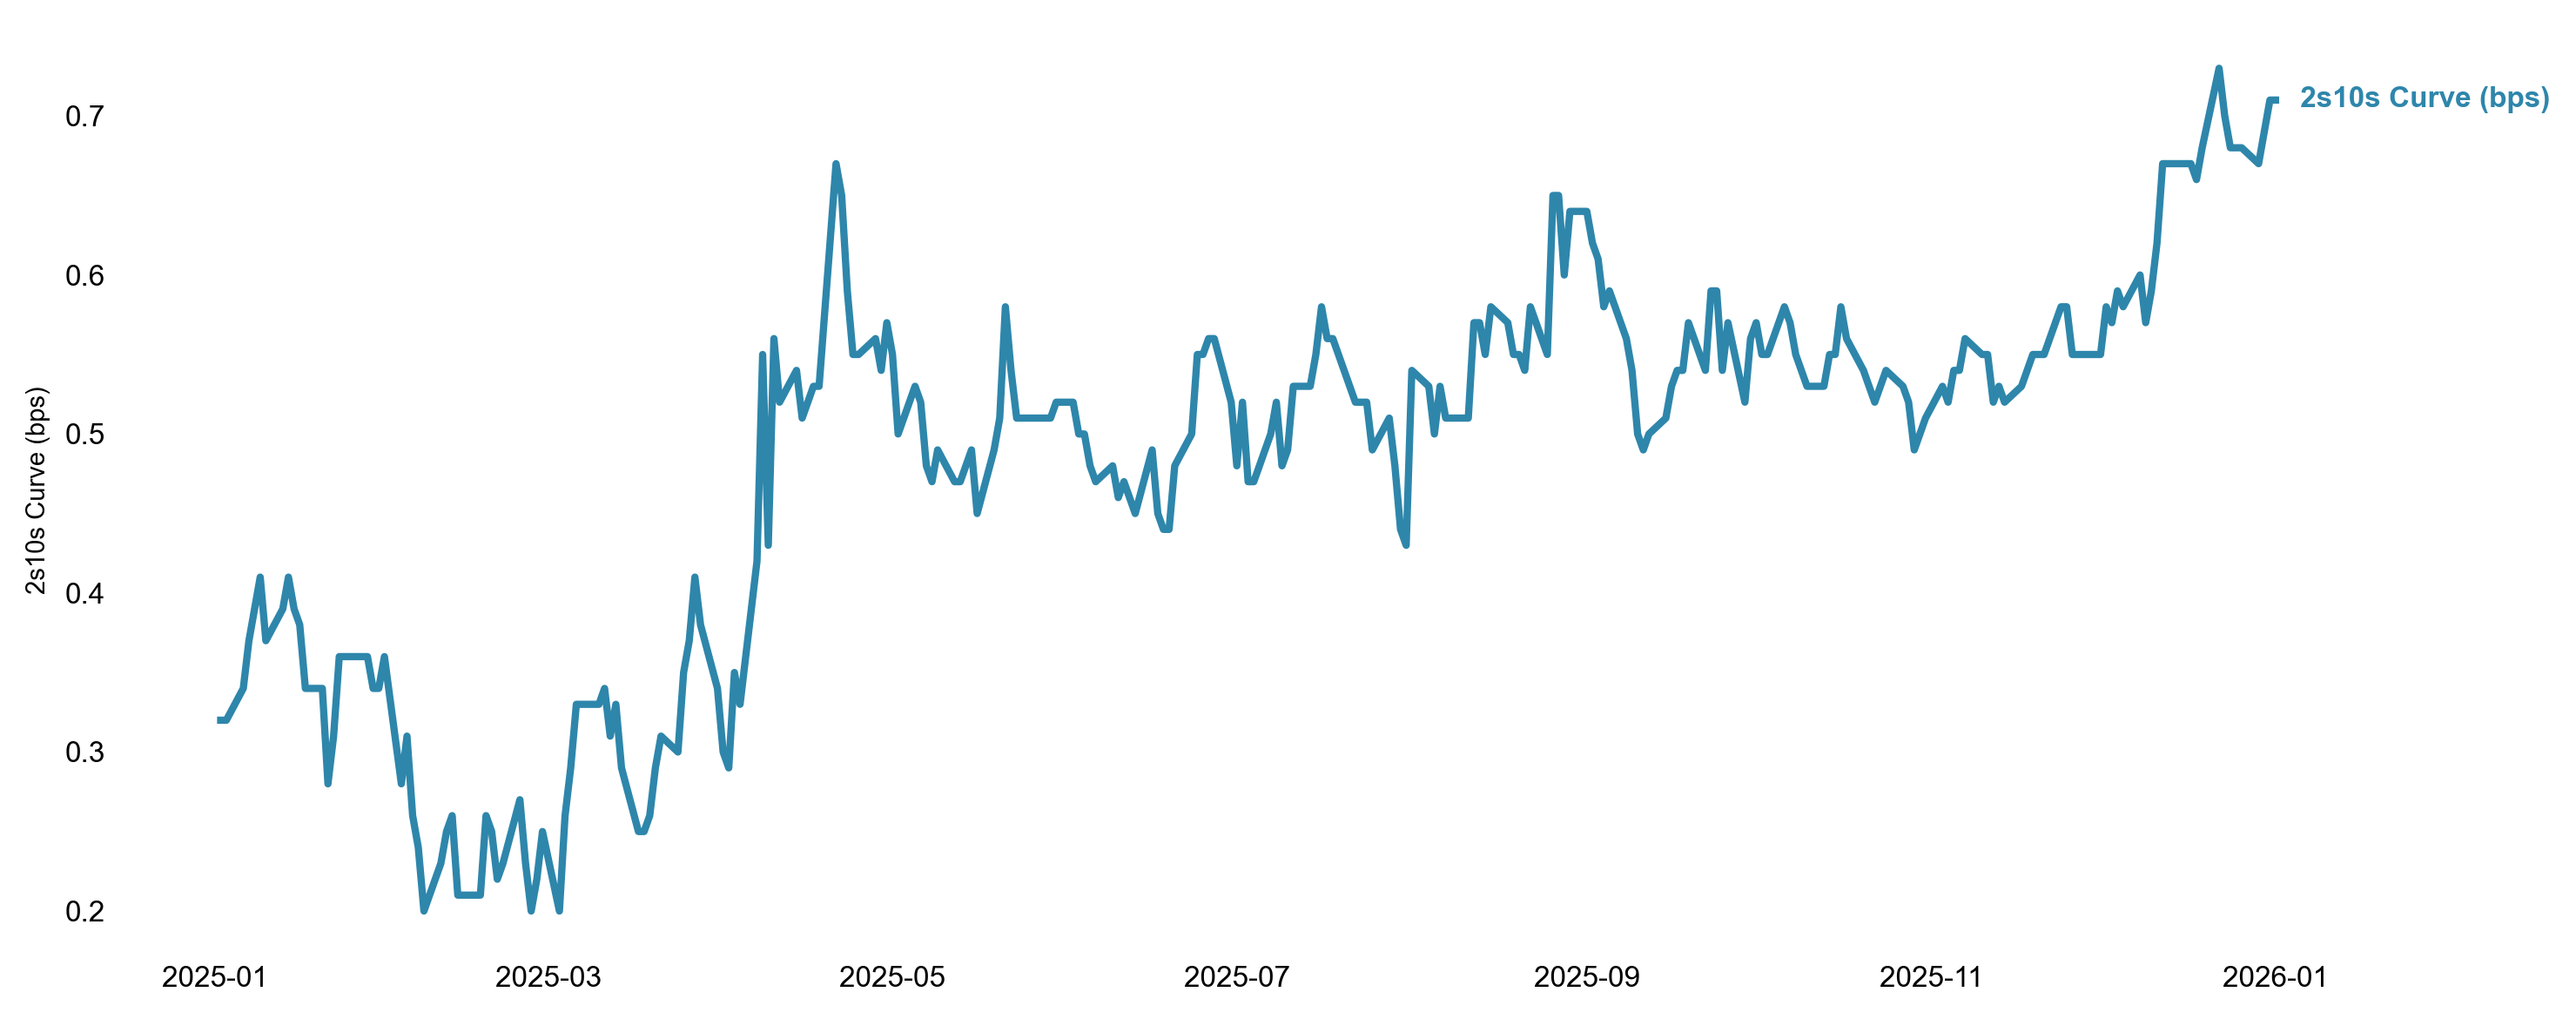


✓ Plot saved to: /Users/jdawg/Desktop/2s10s.png


In [48]:
ten_two["T10Y2Y"] = ten_two["T10Y2Y"].ffill()
ten_two['observation_date'] = pd.to_datetime(ten_two['observation_date'])

# Remove any remaining NaN values
ten_two_filtered = ten_two.dropna()

print(f"Date range: {ten_two_filtered['observation_date'].min()} to {ten_two_filtered['observation_date'].max()}")
print(f"Number of weeks: {len(ten_two_filtered)}")

fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

# Plot open interest
ax1.plot(ten_two_filtered["observation_date"], 
         ten_two_filtered["T10Y2Y"], 
         color="#2E86AB", 
         linewidth=2, 
         label="2s10s Curve (bps)")

ax1.set_ylabel("2s10s Curve (bps)", color="black", fontsize=7)
ax1.tick_params(axis="y", length=0, labelsize=8)
ax1.tick_params(axis="x", length=0, labelsize=8)

# Add label at the end
last_date = ten_two_filtered["observation_date"].iloc[-1]
last_oi = ten_two_filtered["T10Y2Y"].iloc[-1]

ax1.text(last_date + pd.Timedelta(days=3), last_oi, ' 2s10s Curve (bps)', 
         fontsize=8, color='#2E86AB', va='center', ha='left', weight='bold')

# Remove spines
for spine in ax1.spines.values():
    spine.set_visible(False)

ax1.grid(False)

fig.tight_layout()
plt.savefig("/Users/jdawg/Desktop/2s10s.png", bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: /Users/jdawg/Desktop/2s10s.png")